In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selectinf.Simulation.spline import b_spline
from selectinf.Simulation.spline_instance import gaussian_group_polynomial_interaction_instance
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
from selectinf.reluctant_interaction import (SPAM, split_SPAM)
from selectinf.base import selected_targets_interaction
import regreg.api as rr
from selectinf.base import selected_targets
from selectinf.base import restricted_estimator
import scipy.stats
import statsmodels.api as sm
import sys

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


In [22]:
def interaction_t_test_single(X_E, Y, Y_mean, interaction, level=0.9):
    interaction = interaction.reshape(-1, 1)
    X_aug = np.concatenate((X_E, interaction), axis=1)
    n, p_prime = X_aug.shape
    
    S = np.linalg.inv(X_aug.T @ X_aug)
    H = X_aug @ S @ X_aug.T
    e = Y - H @ Y
    sigma_hat = np.sqrt(e.T @ e / (n - p_prime))
    sd = sigma_hat * np.sqrt(S[p_prime-1,p_prime-1])
    
    beta_hat = S @ X_aug.T @ Y
    beta_targets = S @ X_aug.T @ Y_mean
    
    # Normal quantiles
    qt_low = scipy.stats.t.ppf((1 - level) / 2, df=n-p_prime)
    qt_up = scipy.stats.t.ppf(1 - (1 - level) / 2, df=n-p_prime)
    assert np.abs(np.abs(qt_low) - np.abs(qt_up)) < 10e-6

    # Construct confidence intervals
    interval_low = beta_hat[p_prime-1] + qt_low * sd
    interval_up = beta_hat[p_prime-1] + qt_up * sd
    
    target = beta_targets[p_prime-1]
    
    ### Test
    mat = np.array([interval_up, interval_low, target])
    # print("intervals: ", mat)
    
    coverage = (target > interval_low) * (target < interval_up)
    
    return coverage, interval_up - interval_low, (interval_up*interval_low > 0)

def interaction_t_test_single_sm(X_E, Y, Y_mean, interaction, level=0.9):
    interaction = interaction.reshape(-1, 1)
    X_aug = np.concatenate((X_E, interaction), axis=1)
    n, p_prime = X_aug.shape
    
    # Fit linear regression model
    model = sm.OLS(Y, X_aug).fit()
    # Get confidence intervals for the model coefficients
    confidence_interval = model.conf_int(alpha=1-level)[p_prime-1]
    
    # Solve for target
    model_target = sm.OLS(Y_mean, X_aug).fit()
    beta_targets = model_target.params
    
    # Construct confidence intervals
    interval_low = confidence_interval[0]
    interval_up = confidence_interval[1]
    
    target = beta_targets[p_prime-1]
    
    coverage = (target > interval_low) * (target < interval_up)
    
    return coverage, interval_up - interval_low, (interval_up*interval_low > 0)
    
    
    
# T-test for all interaction terms
def interaction_t_tests_all(X_E, Y, Y_mean, n_features, active_vars_flag,
                            interactions, selection_idx = None,
                            level=0.9, mode = "allpairs"):
    coverage_list = []
    length_list = []
    selected_interactions = []
    
    if mode == "allpairs":
        for i in range(n_features):
            for j in range(i+1, n_features):
                if selection_idx is not None:
                    interaction_ij = interactions[(i,j)][~selection_idx]
                else:
                    interaction_ij = interactions[(i,j)]
                coverage, length, selected\
                    = interaction_t_test_single(X_E, Y, Y_mean, 
                                                   interaction_ij,
                                                   level=level)
                coverage_list.append(coverage)
                length_list.append(length)
                if selected:
                    selected_interactions.append((i,j))
    elif mode == 'weakhierarchy':
        for i in range(n_features):
            for j in range(i+1, n_features):
                if active_vars_flag[i] or active_vars_flag[j]:
                    if selection_idx is not None:
                        interaction_ij = interactions[(i,j)][~selection_idx]
                    else:
                        interaction_ij = interactions[(i,j)]
                    coverage, length, selected\
                        = interaction_t_test_single(X_E, Y, Y_mean, 
                                                       interaction_ij,
                                                       level=level)
                    coverage_list.append(coverage)
                    length_list.append(length)
                    if selected:
                        selected_interactions.append((i,j))    
    elif mode == 'stronghierarchy':
        for i in range(n_features):
            for j in range(i+1, n_features):
                if active_vars_flag[i] and active_vars_flag[j]:
                    #print(i,j)
                    if selection_idx is not None:
                        interaction_ij = interactions[(i,j)][~selection_idx]
                    else:
                        interaction_ij = interactions[(i,j)]
                    coverage, length, selected\
                        = interaction_t_test_single(X_E, Y, Y_mean,
                                                       interaction_ij,
                                                       level=level)
                    coverage_list.append(coverage)
                    length_list.append(length)
                    if selected:
                        selected_interactions.append((i,j))
    
    return np.array(coverage_list), np.array(length_list), selected_interactions

def naive_inference_spline_inter(X, Y, groups, Y_mean, const, 
                                 n_features, interactions, intercept=False,
                                 weight_frac=1.25, level=0.9, mode="allpairs"):
    """
    Naive inference post-selection for interaction filtering
        X: design matrix, with/without intercept, depending on the value of intercept
        Y: response
        Y_mean: True mean of Y given X
        const: LASSO/Group LASSO solver
        n_features: Number of features, 
            p in the case of linear main effects
            |G| in the case of basis expansion
        interactions: Dictionary of interactions, keys are of form (i,j), i>j
    """
    n, p = X.shape

    ##estimate noise level in data

    sigma_ = np.std(Y)
    if n > p:
        dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
    else:
        dispersion = sigma_ ** 2

    sigma_ = np.sqrt(dispersion)

    ##solve group LASSO with group penalty weights = weights
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    # Don't penalize intercept
    if intercept:
        weights[0] = 0

    conv = const(X=X,
                 Y=Y,
                 groups=groups,
                 weights=weights,
                 useJacobian=True,
                 perturb=np.zeros(p),
                 ridge_term=0.)

    signs, _ = conv.fit()
    nonzero = signs != 0
    
    selected_groups = conv.selection_variable['active_groups']
    G_E = len(selected_groups)

    if G_E > (1 + intercept):
        # E: nonzero flag
        X_E = X[:, nonzero]
        
        active_flag = np.zeros(np.unique(groups).shape[0])
        active_flag[selected_groups] = 1.
        
        if intercept:
            active_vars_flag = active_flag[1:]
        else:
            active_vars_flag = active_flag
        
        coverages, lengths, selected_interactions\
            = interaction_t_tests_all(X_E, Y, Y_mean, n_features, 
                                      active_vars_flag, interactions, 
                                      level=level, mode = mode)
        print("Naive Selection Size:", len(selected_interactions))
        return coverages, lengths, selected_interactions

    return None, None, None

def data_splitting_spline_inter(X, Y, groups, Y_mean, const, 
                                n_features, interactions, intercept=False,
                                weight_frac=1.25, level=0.9,
                                proportion=0.5, mode="allpairs"):
    """
    Naive inference post-selection for interaction filtering
        X: design matrix, with/without intercept, depending on the value of intercept
        Y: response
        Y_mean: True mean of Y given X
        const: LASSO/Group LASSO solver
        n_features: Number of features, 
            p in the case of linear main effects
            |G| in the case of basis expansion
        interactions: Dictionary of interactions, keys are of form (i,j), i>j
    """
    n, p = X.shape
    
    pi_s = proportion
    subset_select = np.zeros(n, np.bool_)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]
    X_notS = X[~subset_select, :]
    Y_notS = Y[~subset_select]

    ##estimate noise level in data

    sigma_ = np.std(Y_S)
    if n > p:
        dispersion = np.linalg.norm(Y_S - X_S.dot(np.linalg.pinv(X_S).dot(Y_S))) ** 2 / (n1 - p)
    else:
        dispersion = sigma_ ** 2

    sigma_ = np.sqrt(dispersion)

    ##solve group LASSO with group penalty weights = weights
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    # Don't penalize intercept
    if intercept:
        weights[0] = 0

    conv = const(X=X_S,
                 Y=Y_S,
                 groups=groups,
                 weights=weights,
                 useJacobian=True,
                 perturb=np.zeros(p),
                 ridge_term=0.)

    signs, _ = conv.fit()
    nonzero = signs != 0
    
    selected_groups = conv.selection_variable['active_groups']
    G_E = len(selected_groups)
    
    if G_E > (1 + intercept):
        # E: nonzero flag
        X_E = X_notS[:, nonzero]
        
        active_flag = np.zeros(np.unique(groups).shape[0])
        active_flag[selected_groups] = 1.
        
        if intercept:
            active_vars_flag = active_flag[1:]
        else:
            active_vars_flag = active_flag
        
        coverages, lengths, selected_interactions\
             = interaction_t_tests_all(X_E, Y_notS, 
                                       Y_mean[~subset_select], n_features, 
                                       active_vars_flag, interactions, subset_select,
                                       level=level, mode = mode)
        
        print("DS Selection Size:", len(selected_interactions))
        return coverages, lengths, selected_interactions

    return None, None, None

def interaction_selective_single(conv, dispersion, X_E, Y_mean,
                                 interaction, level=0.9):
    interaction = interaction.reshape(-1, 1)
    X_aug = np.concatenate((X_E, interaction), axis=1)
    n, p_prime = X_aug.shape
    
    #ckpt1 = time.time()
    S = np.linalg.inv(X_aug.T @ X_aug)
    beta_targets = S @ X_aug.T @ Y_mean
    
    target = beta_targets[p_prime-1]
    #ckpt2 = time.time()
    
    #print("target calculation time:", ckpt2 - ckpt1)
    
    conv.setup_interaction(interaction=interaction)
    #ckpt3 = time.time()
    #print("setup interaction time:", ckpt3 - ckpt2)
    conv.setup_inference(dispersion=dispersion)
    #ckpt4 = time.time()
    #print("setup inference time:", ckpt4 - ckpt3)
    
    target_spec = selected_targets_interaction(conv.loglike,
                                               conv.observed_soln,
                                               interaction=interaction,
                                               dispersion=dispersion,
                                               leastsq=True)
    #ckpt5 = time.time()
    #print("selected_targets_interaction time:", ckpt5 - ckpt4)
    result,_ = conv.inference(target_spec,
                              method='selective_MLE',
                              level=level)
    #ckpt6 = time.time()
    #print("MLE calculation time:", ckpt6 - ckpt5)

    # pval = result['pvalue']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])
    (interval_low, interval_up) = intervals[-1,:]
    
    coverage = (target > interval_low) * (target < interval_up)
    
    return coverage, interval_up - interval_low, (interval_up*interval_low > 0)

def interaction_selective_tests_all(conv, dispersion, 
                                    X_E, Y_mean, n_features, active_vars_flag,
                                    interactions, 
                                    level=0.9, mode = "allpairs"):
    coverage_list = []
    length_list = []
    selected_interactions = []
    
    if mode == "allpairs":
        for i in range(n_features):
            for j in range(i+1, n_features):
                interaction_ij = interactions[(i,j)]
                coverage, length, selected\
                    = interaction_selective_single(conv, dispersion, X_E, Y_mean,
                                                   interaction_ij, level=level)
                coverage_list.append(coverage)
                length_list.append(length)
                if selected:
                    selected_interactions.append((i,j))
    elif mode == 'weakhierarchy':
        for i in range(n_features):
            for j in range(i+1, n_features):
                if active_vars_flag[i] or active_vars_flag[j]:
                    interaction_ij = interactions[(i,j)]
                    coverage, length, selected\
                        = interaction_selective_single(conv, dispersion, X_E, Y_mean,
                                                   interaction_ij, level=level)
                    coverage_list.append(coverage)
                    length_list.append(length)
                    if selected:
                        selected_interactions.append((i,j))    
    elif mode == 'stronghierarchy':
        #print("|E|:", active_vars_flag.sum())
        #print("n inter:", active_vars_flag * (active_vars_flag - 1) / 2)
        for i in range(n_features):
            for j in range(i+1, n_features):
                if active_vars_flag[i] and active_vars_flag[j]:
                    interaction_ij = interactions[(i,j)]
                    coverage, length, selected\
                        = interaction_selective_single(conv, dispersion, X_E, Y_mean,
                                                   interaction_ij, level=level)
                    coverage_list.append(coverage)
                    length_list.append(length)
                    if selected:
                        selected_interactions.append((i,j))
    
    return np.array(coverage_list), np.array(length_list), selected_interactions

def MLE_inference_quad_inter(X, Y, Y_mean, groups,
                             n_features, interactions, intercept=False,
                             weight_frac=1.25, level=0.9,
                             proportion=0.5, mode="allpairs"):
    """
    Naive inference post-selection for interaction filtering
        X: design matrix, with/without intercept, depending on the value of intercept
        Y: response
        Y_mean: True mean of Y given X
        const: LASSO/Group LASSO solver
        n_features: Number of features, 
            p in the case of linear main effects
            |G| in the case of basis expansion
        interactions: Dictionary of interactions, keys are of form (i,j), i>j
    """
    const = SPAM.gaussian
    
    n, p = X.shape
    
    ##estimate noise level in data
    
    sigma_ = np.std(Y)
    if n > p:
        dispersion\
            = (np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 
               / (n - p))
    else:
        dispersion = sigma_ ** 2
    
    sigma_ = np.sqrt(dispersion)
    
    ##solve group LASSO with group penalty weights = weights
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    # Don't penalize intercept
    if intercept:
        weights[0] = 0
    
    prop_scalar = (1 - proportion) / proportion
    
    conv = const(X=X,
                 Y=Y,
                 groups=groups,
                 weights=weights,
                 useJacobian=True,
                 ridge_term=0.,
                 cov_rand = X.T @ X * prop_scalar)
    
    signs, _ = conv.fit()
    nonzero = signs != 0
    
    selected_groups = conv.selection_variable['active_groups']
    G_E = len(selected_groups)

    if nonzero.sum() > 1+intercept:
        X_E = X[:, nonzero]
        selected_groups = conv.selection_variable['active_groups']
        active_flag = np.zeros(np.unique(groups).shape[0])
        active_flag[selected_groups] = 1.
        
        if intercept:
            active_vars_flag = active_flag[1:]
        else:
            active_vars_flag = active_flag
        
        coverages, lengths, selected_interactions\
            = interaction_selective_tests_all(conv, dispersion,
                                              X_E, Y_mean, n_features, active_vars_flag,
                                              interactions,
                                              level=level, mode = mode)
        
        return coverages, lengths, selected_interactions

    return None, None, None

In [23]:
(design, data_interaction, Y, Y_mean, X,
 active, active_inter_adj, active_inter_list, groups) \
    = gaussian_group_polynomial_interaction_instance(n=500, p=30, s=10, 
                                                     rho=0.5, order=3,
                                                     covar_mean=5,
                                                     SNR = 1, interaction_signal=1,
                                                     random_signs=False,
                                                     scale=True, center=True,
                                                     equicorrelated=True, 
                                                     s_interaction=10,
                                                     structure="stronghierarchy",
                                                     intercept=False)

noise_sd: 1.3314787167207904


In [24]:
design.shape

(500, 90)

In [25]:
const = group_lasso.gaussian
coverages, lengths, selected_inter\
    = data_splitting_spline_inter(X=design, Y=Y, groups=groups,
                                  Y_mean=Y_mean, const=const,
                                  n_features=30, interactions=data_interaction,
                                  weight_frac=1.5, level=0.9, 
                                  proportion=0.5, mode='stronghierarchy')


DS Selection Size: 1


In [26]:
coverages_MLE, lengths_MLE, selected_interactions_MLE\
    = MLE_inference_quad_inter(X=design, Y=Y, groups=groups, Y_mean=Y_mean,
                               n_features=30, interactions=data_interaction,
                               intercept=False, 
                               weight_frac=1.5, level=0.9,
                               proportion=0.5, mode="stronghierarchy")

In [27]:
np.inf - np.inf

nan

In [28]:
design.shape

(500, 90)

In [29]:
def calculate_F1_score_interactions(true_set, selected_list):
    selected_set = set(selected_list)
    # print(true_set, selected_set)

    # precision & recall
    if len(selected_set) > 0:
        precision = len(true_set & selected_set) / len(selected_set)
    else:
        precision = 0
    recall = len(true_set & selected_set) / len(true_set)

    if precision + recall > 0:
        return 2 * precision * recall / (precision + recall)
    else:
        return 0

In [8]:
active_inter_set = set([tuple(row) for row in active_inter_list])
F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                         selected_list=selected_inter)
F1_i_MLE = calculate_F1_score_interactions(true_set=active_inter_set,
                                         selected_list=selected_interactions_MLE)

print(np.mean(coverages))
print(np.mean(lengths))
print(np.mean(F1_i))

print(np.mean(coverages_MLE))
print(np.mean(lengths_MLE))
print(np.mean(F1_i_MLE))

1.0
88.44127277133855
0.0
0.9523809523809523
66.34666534784962
0.0


In [10]:
import copy
li1 = [1, 2, [3, 5], 4]
li2 = copy.copy(li1)
li3 = copy.deepcopy(li1)
li1[0] = 5
print("li2 ID: ", id(li2), "Value: ", li2)
print("li3 ID: ", id(li3), "Value: ", li3)

li2 ID:  140570543179520 Value:  [1, 2, [3, 5], 4]
li3 ID:  140570543180928 Value:  [1, 2, [3, 5], 4]


In [12]:
coverage_naive_l = []
lengths_naive_l = []
coverage_ds_l = []
lengths_ds_l = []
coverage_MLE_l = []
lengths_MLE_l = []
F1_i_naive_l = []
F1_i_ds_l = []
F1_i_MLE_l = []
p=30
intercept_flag = False

def one_sim(p=30):
    const = group_lasso.gaussian
    
    while True:  # run until we get some selection
        no_selection = False
        
        (design, data_interaction, Y, Y_mean, X,
         active, active_inter_adj, active_inter_list, groups) \
            = gaussian_group_polynomial_interaction_instance(n=500, p=p, s=5, 
                                                     rho=0.5, rho_noise=0.5,
                                                             order=3,
                                                   covar_mean=2,
                                                   SNR = 1, interaction_signal=1,
                                                   random_signs=False,
                                                   scale=True, center=True,
                                                   equicorrelated=True, 
                                                     s_interaction=5,
                                                     structure="stronghierarchy",
                                                   intercept=True)
        
        coverages, lengths, selected_interactions\
            = naive_inference_spline_inter(X=design, Y=Y, groups=groups,
                                                  Y_mean=Y_mean, const=const,
                                                  n_features=p, 
                                                  interactions=data_interaction,
                                                  weight_frac=1.5, level=0.9, 
                                                  intercept=intercept_flag,
                                                  mode='stronghierarchy')
        # Convert the matrix into a list of tuples
        active_inter_set = set([tuple(row) for row in active_inter_list])
        
        if coverages is None:
            no_selection = True
        
        if not no_selection:
            print("DATA SPLITTING")
            coverages_ds, lengths_ds, selected_interactions_ds\
                = data_splitting_spline_inter(X=design, Y=Y, groups=groups,
                                                  Y_mean=Y_mean, const=const,
                                                  n_features=p, 
                                                  interactions=data_interaction,
                                                  weight_frac=1.5, level=0.9, 
                                                  intercept=intercept_flag,
                                                 proportion=0.5,
                                                  mode='stronghierarchy')
        if coverages_ds is None:
            no_selection = True
            
        if not no_selection:
            print("MLE")
            coverages_MLE, lengths_MLE, selected_interactions_MLE\
                = MLE_inference_quad_inter(X=design, Y=Y, groups=groups, Y_mean=Y_mean,
                                           n_features=p, interactions=data_interaction,
                                           intercept=intercept_flag, 
                                           weight_frac=1.5, level=0.9,
                                           proportion=0.5, mode="stronghierarchy")
        if coverages_MLE is None:
            no_selection = True
            
        if not no_selection:
            F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                         selected_list=selected_interactions)
            F1_i_ds = calculate_F1_score_interactions(true_set=active_inter_set,
                                          selected_list=selected_interactions_ds)
            F1_i_MLE = calculate_F1_score_interactions(true_set=active_inter_set,
                                         selected_list=selected_interactions_MLE)
            
            return (np.mean(coverages), np.mean(coverages_ds), np.mean(coverages_MLE),
                    np.mean(lengths), np.mean(lengths_ds), np.mean(lengths_MLE),
                    F1_i, F1_i_ds, F1_i_MLE)

for i in range(10):
    const = group_lasso.gaussian

    (avg_cov, avg_cov_ds, avg_cov_MLE,
     avg_len, avg_len_ds, avg_len_MLE,
     F1, F1_ds, F1_MLE) = one_sim()
     
    coverage_naive_l.append(avg_cov)
    lengths_naive_l.append(avg_len)
    coverage_ds_l.append(avg_cov_ds)
    lengths_ds_l.append(avg_len_ds)
    coverage_MLE_l.append(avg_cov_MLE)
    lengths_MLE_l.append(avg_len_MLE)
    F1_i_naive_l.append(F1)
    F1_i_ds_l.append(F1_ds)
    F1_i_MLE_l.append(F1_MLE)
       

noise_sd: 0.6175153926709421
Naive Selection Size: 3
DATA SPLITTING
DS Selection Size: 10
MLE
target calculation time: 0.0008280277252197266
setup interaction time: 0.0003108978271484375
setup inference time: 0.0005519390106201172
selected_targets_interaction time: 0.0009589195251464844
MLE calculation time: 0.38225221633911133
target calculation time: 0.00027179718017578125
setup interaction time: 4.410743713378906e-05
setup inference time: 0.0005891323089599609
selected_targets_interaction time: 0.0005748271942138672
MLE calculation time: 0.3813772201538086
target calculation time: 0.0006651878356933594
setup interaction time: 4.458427429199219e-05
setup inference time: 0.0006892681121826172
selected_targets_interaction time: 0.0006117820739746094
MLE calculation time: 0.26642513275146484
target calculation time: 0.0008721351623535156
setup interaction time: 0.00012493133544921875
setup inference time: 0.0006761550903320312
selected_targets_interaction time: 0.0005848407745361328
MLE

KeyboardInterrupt: 

In [20]:
print(np.mean(np.array(coverage_naive_l)))
print(np.mean(np.array(coverage_ds_l)))
print(np.mean(np.array(coverage_MLE_l)))
print(np.mean(np.array(lengths_naive_l)))
print(np.mean(np.array(lengths_ds_l)))
print(np.mean(np.array(lengths_MLE_l)))
print(np.mean(np.array(F1_i_naive_l)))
print(np.mean(np.array(F1_i_ds_l)))
print(np.mean(np.array(F1_i_MLE_l)))

0.8751587301587301
0.8735281385281386
0.8445598845598846
5.083578497028424
7.250676361356568
6.861291372426285
0.017523809523809525
0.0058823529411764705
0.030982276232387262


In [30]:
def interaction_filter_vary_mode(nsim=100, weight=1., full=False, rho_n=0):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []
    oper_char["|G|"] = []
    oper_char["mode"] = []
    p = 30
    intercept_flag = False

    for mode in ["stronghierarchy", "weakhierarchy", "allpairs"]:  
        for i in range(nsim):
            print(i, "th simulation for mode ", mode)

            inst, const = (gaussian_group_polynomial_interaction_instance,
                           group_lasso.gaussian)

            while True:  # run until we get some selection
                (design, data_interaction, Y, Y_mean, X,
                 active, active_inter_adj, active_inter_list, groups) \
                    = inst(n=500, p=p, s=5, rho=0.5, rho_noise=rho_n, 
                           order=3, full_corr=full,
                           covar_mean=2, SNR = 0.5, interaction_signal=1,
                           random_signs=False, scale=True, center=True,
                           equicorrelated=True, s_interaction=5,
                           structure="stronghierarchy", intercept=intercept_flag)

                noselection = False  # flag for a certain method having an empty selected set

                if not noselection:
                    # MLE inference
                    coverages_ds, lengths_ds, selected_interactions_ds \
                        = data_splitting_spline_inter(X=design, Y=Y, groups=groups,
                                                  Y_mean=Y_mean, const=const,
                                                  n_features=p, 
                                                  interactions=data_interaction,
                                                  weight_frac=weight, level=0.9, 
                                                  intercept=intercept_flag,
                                                 proportion=0.5,
                                                  mode=mode)
                    
                    # Convert the matrix into a list of tuples
                    active_inter_set = set([tuple(row) for row in active_inter_list])
                    noselection = (coverages_ds is None)

                if not noselection:
                    coverages, lengths, selected_interactions \
                        = naive_inference_spline_inter(X=design, Y=Y, groups=groups,
                                                  Y_mean=Y_mean, const=const,
                                                  n_features=p, 
                                                  interactions=data_interaction,
                                                  weight_frac=weight, level=0.9, 
                                                  intercept=intercept_flag,
                                                  mode=mode)
                    noselection = (coverages is None)
                
                if not noselection:
                    coverages_MLE, lengths_MLE, selected_interactions_MLE\
                        = MLE_inference_quad_inter(X=design, Y=Y, groups=groups, 
                                                   Y_mean=Y_mean,
                                                   n_features=p, interactions=data_interaction,
                                                   intercept=intercept_flag, 
                                                   weight_frac=weight, level=0.9,
                                                   proportion=0.5, mode=mode)
                    noselection = (coverages_MLE is None)
                    
                if not noselection:
                    F1_i_ds \
                        = calculate_F1_score_interactions(true_set=active_inter_set,
                                            selected_list=selected_interactions_ds)
                    F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                            selected_list=selected_interactions)
                    F1_i_MLE = calculate_F1_score_interactions(true_set=active_inter_set,
                                            selected_list=selected_interactions_MLE)
                    # Naive
                    oper_char["coverage rate"].append(np.mean(coverages))
                    oper_char["avg length"].append(np.mean(lengths))
                    oper_char["F1 score interaction"].append(F1_i)
                    oper_char["method"].append('Naive')
                    oper_char["|G|"].append(len(selected_interactions))
                    oper_char["mode"].append(mode)

                    # Data splitting
                    oper_char["coverage rate"].append(np.mean(coverages_ds))
                    oper_char["avg length"].append(np.mean(lengths_ds))
                    oper_char["F1 score interaction"].append(F1_i_ds)
                    oper_char["method"].append('Data Splitting')
                    oper_char["|G|"].append(len(selected_interactions_ds))
                    oper_char["mode"].append(mode)
                    
                    # MLE
                    oper_char["coverage rate"].append(np.mean(coverages_MLE))
                    oper_char["avg length"].append(np.mean(lengths_MLE))
                    oper_char["F1 score interaction"].append(F1_i_MLE)
                    oper_char["method"].append('MLE')
                    oper_char["|G|"].append(len(selected_interactions_MLE))
                    oper_char["mode"].append(mode)

                    break  # Go to next iteration if we have some selection
    return oper_char

In [33]:
oper_char = interaction_filter_vary_mode(nsim=10, weight=4., full=True, rho_n=0)
oper_char_df = pd.DataFrame.from_dict(oper_char)
oper_char_df.to_csv('polynomial_basis_simulation_new' + '.csv',
                        index=False)

0 th simulation for mode  stronghierarchy
noise_sd: 0.9548694623105001
noise_sd: 0.981712302056155
noise_sd: 0.9997229421847651
noise_sd: 0.9830674416725974
DS Selection Size: 0
Naive Selection Size: 2
1 th simulation for mode  stronghierarchy
noise_sd: 0.9794786249611874
noise_sd: 1.0060648990182501
noise_sd: 1.0166034299190518
DS Selection Size: 0
Naive Selection Size: 1
2 th simulation for mode  stronghierarchy
noise_sd: 0.9846824915109933
noise_sd: 1.0101860867197108
DS Selection Size: 0
Naive Selection Size: 4
3 th simulation for mode  stronghierarchy
noise_sd: 0.9823091757820371
noise_sd: 1.0031600111797732
DS Selection Size: 0
Naive Selection Size: 0
4 th simulation for mode  stronghierarchy
noise_sd: 1.0007276101975469
noise_sd: 0.9993858688712177
noise_sd: 1.007034080252043
noise_sd: 0.9922276760008168
noise_sd: 0.9799434766690287
noise_sd: 0.9643192665616993
noise_sd: 0.9870301053911701
noise_sd: 0.9738618448845999
noise_sd: 1.000950364878965
noise_sd: 0.9686335433207538
DS S

In [48]:
oper_char = interaction_filter_vary_mode(nsim=30, weight=2., full=True, rho_n=0)
oper_char_df = pd.DataFrame.from_dict(oper_char)
oper_char_df.to_csv('polynomial_basis_simulation_lw1' + '.csv',
                        index=False)

0 th simulation for mode  stronghierarchy
noise_sd: 0.9622945593148341
DS Selection Size: 3
Naive Selection Size: 4
1 th simulation for mode  stronghierarchy
noise_sd: 1.0000582491160326
DS Selection Size: 0
Naive Selection Size: 3
2 th simulation for mode  stronghierarchy
noise_sd: 0.9870351243931968
DS Selection Size: 1
Naive Selection Size: 1
3 th simulation for mode  stronghierarchy
noise_sd: 1.0071648652774963
DS Selection Size: 2
Naive Selection Size: 6
4 th simulation for mode  stronghierarchy
noise_sd: 0.9641608670830825
DS Selection Size: 5
Naive Selection Size: 7
5 th simulation for mode  stronghierarchy
noise_sd: 0.9646868905128556
DS Selection Size: 5
Naive Selection Size: 2
6 th simulation for mode  stronghierarchy
noise_sd: 0.9857351055255192
DS Selection Size: 2
Naive Selection Size: 2
7 th simulation for mode  stronghierarchy
noise_sd: 1.0139207834793882
DS Selection Size: 6
Naive Selection Size: 3
8 th simulation for mode  stronghierarchy
noise_sd: 0.9843094110663277
D

In [34]:
oper_char = interaction_filter_vary_mode(nsim=30, weight=2., full=False, rho_n=0.5)
oper_char_df = pd.DataFrame.from_dict(oper_char)
oper_char_df.to_csv('polynomial_basis_simulation_blockrho_lw1' + '.csv',
                        index=False)

0 th simulation for mode  stronghierarchy
noise_sd: 0.9740511523517599
DS Selection Size: 1
Naive Selection Size: 2
1 th simulation for mode  stronghierarchy
noise_sd: 0.9996816893354231
DS Selection Size: 1
Naive Selection Size: 1
2 th simulation for mode  stronghierarchy
noise_sd: 0.9796106658329875
DS Selection Size: 1
Naive Selection Size: 2
3 th simulation for mode  stronghierarchy
noise_sd: 0.9862076027139899
DS Selection Size: 1
Naive Selection Size: 1
4 th simulation for mode  stronghierarchy
noise_sd: 0.9775823190587377
DS Selection Size: 0
Naive Selection Size: 1
5 th simulation for mode  stronghierarchy
noise_sd: 0.9750762349347222
DS Selection Size: 0
Naive Selection Size: 0
6 th simulation for mode  stronghierarchy
noise_sd: 0.9786908092706067
DS Selection Size: 0
Naive Selection Size: 0
7 th simulation for mode  stronghierarchy
noise_sd: 0.9885261684274339
DS Selection Size: 1
Naive Selection Size: 1
8 th simulation for mode  stronghierarchy
noise_sd: 1.0027266392246976
D

In [37]:
oper_char = interaction_filter_vary_mode(nsim=30, weight=2., full=False, rho_n=0.)
oper_char_df = pd.DataFrame.from_dict(oper_char)
oper_char_df.to_csv('polynomial_basis_simulation_blockrho_iidnoise_lw1' + '.csv',
                        index=False)

0 th simulation for mode  stronghierarchy
noise_sd: 0.9581061358632537
DS Selection Size: 1
Naive Selection Size: 0
1 th simulation for mode  stronghierarchy
noise_sd: 0.988933924573018
DS Selection Size: 0
Naive Selection Size: 0
2 th simulation for mode  stronghierarchy
noise_sd: 1.0045634211833359
DS Selection Size: 0
Naive Selection Size: 0
3 th simulation for mode  stronghierarchy
noise_sd: 0.9484954259102445
DS Selection Size: 0
Naive Selection Size: 1
4 th simulation for mode  stronghierarchy
noise_sd: 1.0132374686655223
DS Selection Size: 1
Naive Selection Size: 0
5 th simulation for mode  stronghierarchy
noise_sd: 0.9753337222925352
DS Selection Size: 2
Naive Selection Size: 1
6 th simulation for mode  stronghierarchy
noise_sd: 1.025229464160961
DS Selection Size: 0
Naive Selection Size: 0
7 th simulation for mode  stronghierarchy
noise_sd: 0.9867228933887663
DS Selection Size: 1
Naive Selection Size: 2
8 th simulation for mode  stronghierarchy
noise_sd: 0.9915584929970765
DS 

In [34]:
oper_char_df1 = pd.read_csv("polynomial_basis_simulation_new.csv", index_col=False)

In [49]:
oper_char_df2 = pd.read_csv("polynomial_basis_simulation_lw1.csv", index_col=False)

In [35]:
oper_char_df3 = pd.read_csv("polynomial_basis_simulation_blockrho_lw1.csv", index_col=False)

In [38]:
oper_char_df4 = pd.read_csv("polynomial_basis_simulation_blockrho_iidnoise_lw1.csv", index_col=False)

In [35]:
pd.DataFrame.from_dict(oper_char)

,coverage rate,avg length,method,F1 score interaction,|G|,mode
0,0.944444,18.051134,Naive,0.000000,2,stronghierarchy
1,1.000000,28.753736,Data Splitting,0.000000,0,stronghierarchy
2,0.928571,18.875131,MLE,0.000000,2,stronghierarchy
3,0.833333,19.551260,Naive,0.333333,1,stronghierarchy
4,1.000000,31.944546,Data Splitting,0.000000,0,stronghierarchy
...,...,...,...,...,...,...
85,0.832184,6.533143,Data Splitting,0.041451,188,allpairs
86,0.972414,8.412248,MLE,0.235294,12,allpairs
87,0.777011,5.913651,Naive,0.000000,17,allpairs
88,0.947126,7.401095,Data Splitting,0.035874,218,allpairs


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
def plotting(oper_char_df, x_axis='p', hue='method'):
    oper_char_df_copy = oper_char_df.copy()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(10,6))

    #print("Mean coverage rate/length:")
    #print(oper_char_df.groupby([x_axis, hue]).mean())
    my_palette = {"MLE": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    alias = {"stronghierarchy": "Strong", 
             "weakhierarchy": "Weak", 
             "allpairs": "All"}
    if x_axis == 'mode':
        oper_char_df_copy['mode'] = oper_char_df_copy['mode'].map(alias)

    cov_plot = sns.boxplot(y=oper_char_df_copy["coverage rate"],
                           x=oper_char_df_copy[x_axis],
                           hue=oper_char_df_copy[hue],
                           palette=my_palette,
                           orient="v", ax=ax1,
                           showmeans=True,
                           linewidth=1)
    cov_plot.set(title='Coverage')
    cov_plot.set_ylim(0., 1.05)
    #plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    #ax1.set_ylabel("")  # remove y label, but keep ticks
    ax1.set_xlabel(x_axis)

    len_plot = sns.boxplot(y=oper_char_df_copy["avg length"],
                           x=oper_char_df_copy[x_axis],
                           hue=oper_char_df_copy[hue],
                           palette=my_palette,
                           orient="v", ax=ax2,
                           linewidth=1)
    len_plot.set(title='Length')
    # len_plot.set_ylim(0, 100)
    # len_plot.set_ylim(3.5, 7.8)
    # plt.tight_layout()
    # ax2.set_ylabel("")  # remove y label, but keep ticks
    ax2.set_xlabel(x_axis)

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    fig.subplots_adjust(bottom=0.15)
    fig.legend(handles, labels, loc='lower center', ncol=4)
    

    F1_plot = sns.boxplot(y=oper_char_df_copy["F1 score interaction"],
                          x=oper_char_df_copy[x_axis],
                          hue=oper_char_df_copy[hue],
                          palette=my_palette,
                          orient="v", ax=ax3,
                          linewidth=1)
    F1_plot.set(title='F1 score')
    ax3.set_xlabel(x_axis)
    
    size_plot = sns.boxplot(y=oper_char_df_copy["|G|"],
                          x=oper_char_df_copy[x_axis],
                          hue=oper_char_df_copy[hue],
                          palette=my_palette,
                          orient="v", ax=ax4,
                          linewidth=1)
    size_plot.set(title='|G|')
    ax4.set_xlabel(x_axis)

    cov_plot.legend_.remove()
    len_plot.legend_.remove()
    F1_plot.legend_.remove()
    size_plot.legend_.remove()

    #plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    plt.show()

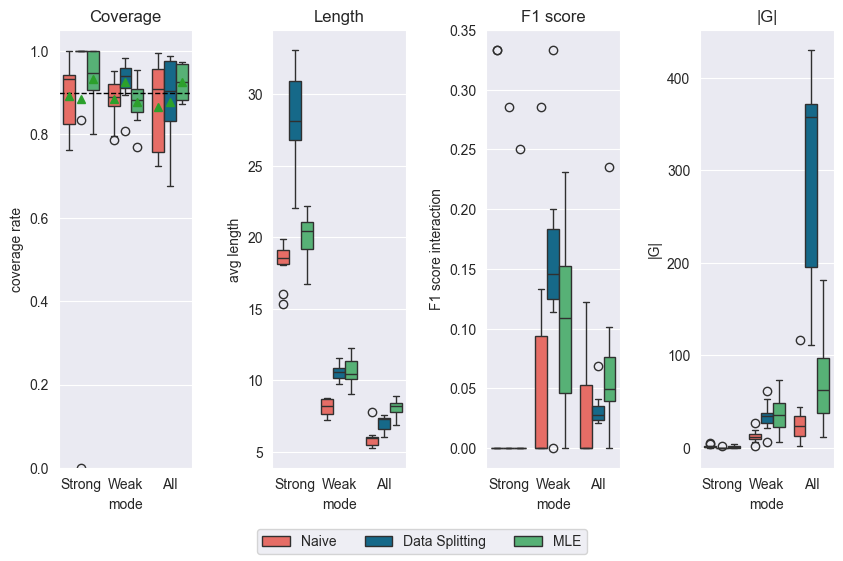

In [37]:
plotting(oper_char_df=oper_char_df1,
         x_axis="mode",
         hue="method")

In [73]:
def interaction_filter_vary_SNR(nsim=100):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []
    oper_char["|G|"] = []
    oper_char["SNR"] = []
    p = 50
    intercept_flag = True

    for SNR in [0.5, 1, 2, 5]:  
        for i in range(nsim):

            inst, const = (gaussian_group_polynomial_interaction_instance,
                           group_lasso.gaussian)

            while True:  # run until we get some selection
                (design, data_interaction, Y, Y_mean, X,
                 active, active_inter_adj, active_inter_list, groups) \
                    = inst(n=500, p=p, s=10, rho=0.5, order=3,
                           covar_mean=5, SNR = SNR, interaction_signal=1,
                           random_signs=False, scale=True, center=True,
                           equicorrelated=True, s_interaction=10,
                           structure="stronghierarchy", intercept=True)

                noselection = False  # flag for a certain method having an empty selected set

                if not noselection:
                    # MLE inference
                    coverages_ds, lengths_ds, selected_interactions_ds \
                        = data_splitting_spline_inter(X=design, Y=Y, groups=groups,
                                                  Y_mean=Y_mean, const=const,
                                                  n_features=p, 
                                                  interactions=data_interaction,
                                                  weight_frac=1., level=0.9, 
                                                  intercept=intercept_flag,
                                                 proportion=0.5,
                                                  mode="weakhierarchy")
                    
                    # Convert the matrix into a list of tuples
                    active_inter_set = set([tuple(row) for row in active_inter_list])
                    noselection = (coverages_ds is None)

                if not noselection:
                    coverages, lengths, selected_interactions \
                        = naive_inference_spline_inter(X=design, Y=Y, groups=groups,
                                                  Y_mean=Y_mean, const=const,
                                                  n_features=p, 
                                                  interactions=data_interaction,
                                                  weight_frac=1., level=0.9, 
                                                  intercept=intercept_flag,
                                                  mode="weakhierarchy")
                    noselection = (coverages is None)

                if not noselection:
                    F1_i_ds \
                        = calculate_F1_score_interactions(true_set=active_inter_set,
                                            selected_list=selected_interactions_ds)
                    F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                            selected_list=selected_interactions)
                    # Naive
                    oper_char["coverage rate"].append(np.mean(coverages))
                    oper_char["avg length"].append(np.mean(lengths))
                    oper_char["F1 score interaction"].append(F1_i)
                    oper_char["method"].append('Naive')
                    oper_char["|G|"].append(len(selected_interactions))
                    oper_char["SNR"].append(SNR)

                    # Data splitting
                    oper_char["coverage rate"].append(np.mean(coverages_ds))
                    oper_char["avg length"].append(np.mean(lengths_ds))
                    oper_char["F1 score interaction"].append(F1_i_ds)
                    oper_char["method"].append('Data Splitting')
                    oper_char["|G|"].append(len(selected_interactions_ds))
                    oper_char["SNR"].append(SNR)

                    break  # Go to next iteration if we have some selection
    return oper_char

In [78]:
oper_char_SNR = interaction_filter_vary_SNR(50)

noise_sd: 1.907634240857713
DS Selection Size: 92
Naive Selection Size: 76
noise_sd: 1.9269582383187924
DS Selection Size: 35
Naive Selection Size: 171
noise_sd: 1.9339185917756165
DS Selection Size: 123
Naive Selection Size: 82
noise_sd: 1.9217567505981838
DS Selection Size: 76
Naive Selection Size: 125
noise_sd: 1.933848774545837
DS Selection Size: 59
Naive Selection Size: 83
noise_sd: 1.9291577622675458
DS Selection Size: 52
Naive Selection Size: 41
noise_sd: 1.8894523295337176
DS Selection Size: 42
Naive Selection Size: 113
noise_sd: 1.9882483480618671
DS Selection Size: 46
Naive Selection Size: 180
noise_sd: 1.9161992234624898
DS Selection Size: 150
Naive Selection Size: 149
noise_sd: 1.9078500215082144
DS Selection Size: 78
Naive Selection Size: 136
noise_sd: 1.9541046985475818
DS Selection Size: 25
Naive Selection Size: 63
noise_sd: 1.9290874566192118
DS Selection Size: 103
Naive Selection Size: 79
noise_sd: 1.926916870089121
DS Selection Size: 99
Naive Selection Size: 57
noise_

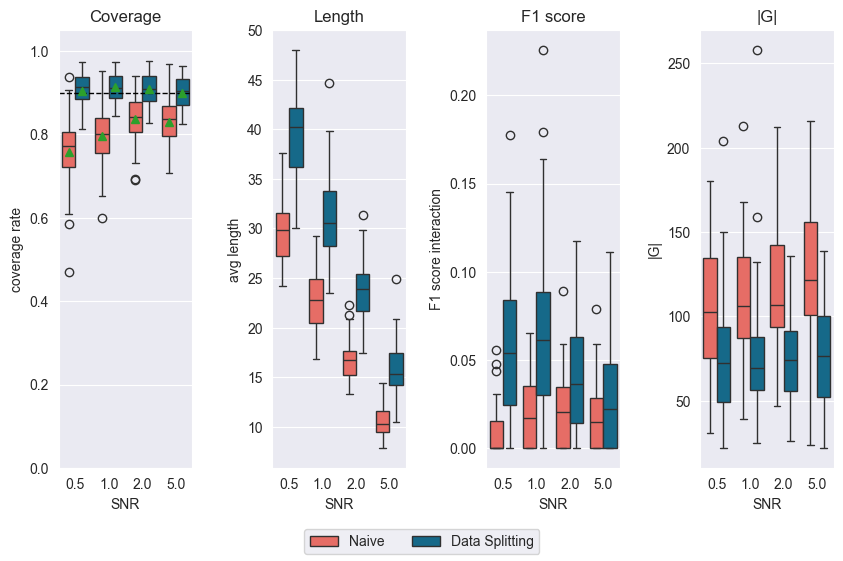

In [79]:
plotting(oper_char_df=pd.DataFrame(oper_char_SNR),
         x_axis="SNR",
         hue="method")